In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.externals import joblib
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report,accuracy_score, f1_score, classification_report , roc_auc_score , precision_recall_curve , average_precision_score, auc, roc_curve, log_loss, accuracy_score, precision_recall_fscore_support
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
import scipy.stats as st
import scikitplot.plotters as skplt

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
data_list = []

for chunk in  pd.read_csv('./data/creditcard.csv', sep=',', chunksize=10000):
    data_list.append(chunk)

df_pd = pd.concat(data_list, axis= 0)
del data_list

df_pd.head(3)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,-2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0


In [4]:
df_pd.columns

Index([u'ID', u'LIMIT_BAL', u'SEX', u'EDUCATION', u'MARRIAGE', u'AGE',
       u'PAY_0', u'PAY_2', u'PAY_3', u'PAY_4', u'PAY_5', u'PAY_6',
       u'BILL_AMT1', u'BILL_AMT2', u'BILL_AMT3', u'BILL_AMT4', u'BILL_AMT5',
       u'BILL_AMT6', u'PAY_AMT1', u'PAY_AMT2', u'PAY_AMT3', u'PAY_AMT4',
       u'PAY_AMT5', u'PAY_AMT6', u'default payment next month'],
      dtype='object')

In [5]:
df_pd.describe(include='all')

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,23999.000000,23999.000000,23999.000000,23999.000000,23999.000000,23999.000000,23999.000000,23999.000000,23999.000000,23999.000000,...,23999.000000,23999.000000,23999.000000,23999.000000,2.399900e+04,23999.000000,23999.000000,23999.000000,23999.000000,23999.000000
mean,12000.000000,165498.715780,1.628276,1.847452,1.557232,35.380849,-0.001667,-0.123463,-0.154756,-0.211675,...,42369.872828,40002.333097,38565.266636,5543.098046,5.815529e+03,4969.431393,4743.656861,4783.643693,5189.573607,0.223718
std,6928.058891,129130.743065,0.483275,0.780004,0.522083,9.271046,1.127136,1.200591,1.204058,1.166573,...,63071.455167,60345.728280,59156.501143,15068.862730,2.079744e+04,16095.929295,14883.554872,15270.703904,17630.718575,0.416744
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6000.500000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2340.500000,1740.000000,1235.000000,1000.000000,8.000000e+02,379.000000,279.500000,244.000000,60.500000,0.000000
50%,12000.000000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,18941.000000,18108.000000,17038.000000,2100.000000,2.000000e+03,1703.000000,1500.000000,1500.000000,1500.000000,0.000000
75%,17999.500000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,52190.000000,49750.000000,48796.500000,5000.000000,5.000000e+03,4347.500000,4000.000000,4005.000000,4000.000000,0.000000
max,23999.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,505000.000000,1.684259e+06,896040.000000,497000.000000,417990.000000,528666.000000,1.000000


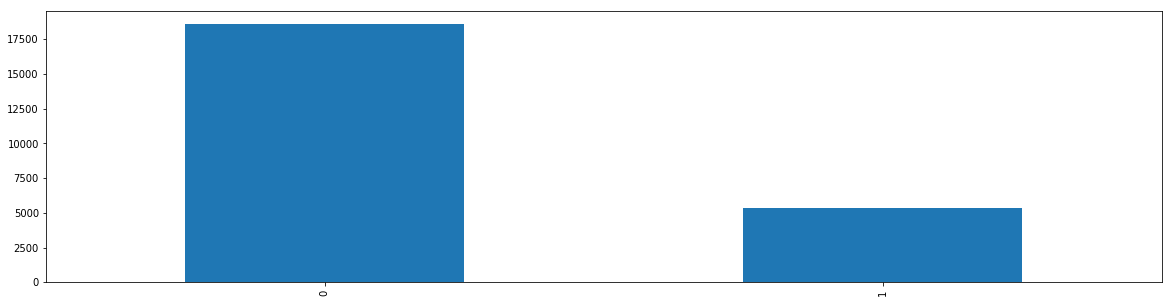

In [6]:
plt.figure(figsize = (20,5))
df_pd['default payment next month'].value_counts().plot(kind="bar");

In [7]:
train = df_pd.drop(['default payment next month'], axis=1)
train = train.drop(['ID'], axis=1)
train_label = df_pd['default payment next month']

#Splitting to train and test
train_X, test_X, train_Y, test_Y = train_test_split(train, train_label,
                                                  test_size = .2,
                                                  random_state=1234)

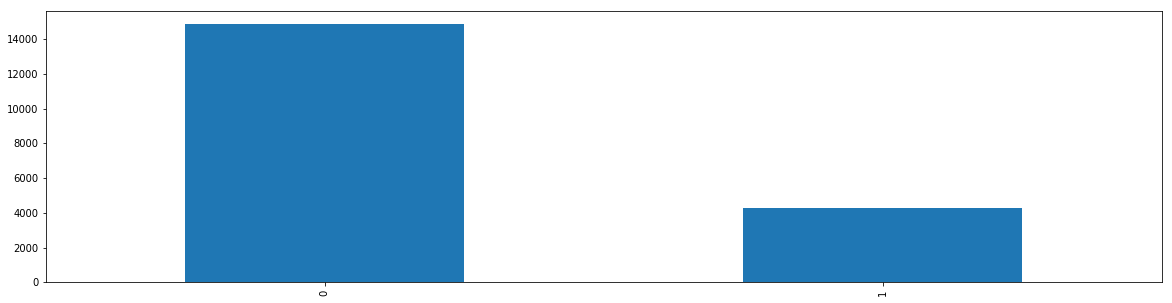

In [8]:
plt.figure(figsize = (20,5))
pd.DataFrame(train_Y)['default payment next month'].value_counts().plot(kind="bar");

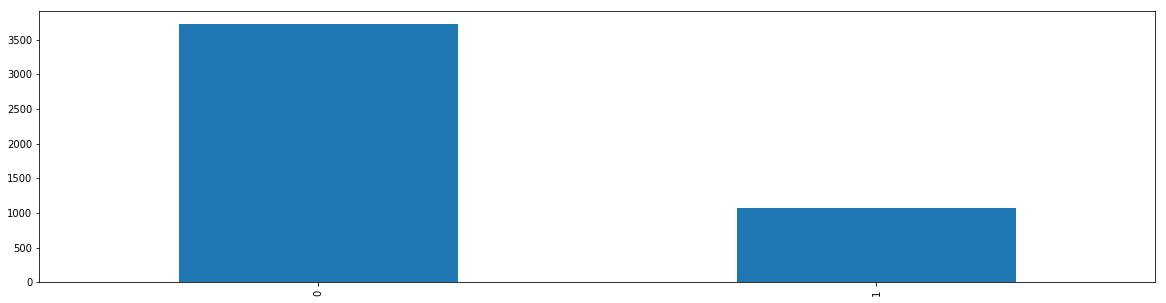

In [9]:
plt.figure(figsize = (20,5))
pd.DataFrame(test_Y)['default payment next month'].value_counts().plot(kind="bar");

In [10]:
#Dummy-encode categorical features
LIMIT_DUMMIES = 100

categorical_to_dummy_encode = [u'SEX', u'EDUCATION', u'MARRIAGE']

# Only keep the top 100 values
def select_dummy_values(train, features):
    dummy_values = {}
    for feature in categorical_to_dummy_encode:
        values = [
            value
            for (value, _) in Counter(train[feature]).most_common(LIMIT_DUMMIES)
        ]
        dummy_values[feature] = values
    return dummy_values

DUMMY_VALUES = select_dummy_values(train_X, categorical_to_dummy_encode)

def dummy_encode_dataframe(df):
    for (feature, dummy_values) in DUMMY_VALUES.items():
        for dummy_value in dummy_values:
            dummy_name = u'%s_value_%s' % (feature, str(dummy_value))
            df[dummy_name] = (df[feature] == dummy_value).astype(float)
        del df[feature]
        print('Dummy-encoded feature %s' % feature)

dummy_encode_dataframe(train_X)
dummy_encode_dataframe(test_X)

Dummy-encoded feature EDUCATION
Dummy-encoded feature MARRIAGE
Dummy-encoded feature SEX
Dummy-encoded feature EDUCATION
Dummy-encoded feature MARRIAGE
Dummy-encoded feature SEX


In [11]:
#Recale numerical features
rescale_features = {u'LIMIT_BAL': u'AVGSTD', u'AGE': u'AVGSTD', u'PAY_0': u'AVGSTD', u'PAY_2': u'AVGSTD', u'PAY_3': u'AVGSTD', u'PAY_4': u'AVGSTD', u'PAY_5': u'AVGSTD', u'PAY_6': u'AVGSTD', u'BILL_AMT1': u'AVGSTD', u'BILL_AMT2': u'AVGSTD', u'BILL_AMT3': u'AVGSTD', u'BILL_AMT4': u'AVGSTD', u'BILL_AMT5': u'AVGSTD', u'BILL_AMT6': u'AVGSTD', u'PAY_AMT1': u'AVGSTD', u'PAY_AMT2': u'AVGSTD', u'PAY_AMT3': u'AVGSTD', u'PAY_AMT4': u'AVGSTD', u'PAY_AMT5': u'AVGSTD', u'PAY_AMT6': u'AVGSTD'}
for (feature_name, rescale_method) in rescale_features.items():
    if rescale_method == 'MINMAX':
        _min = train_X[feature_name].min()
        _max = train_X[feature_name].max()
        scale = _max - _min
        shift = _min
    else:
        shift = train_X[feature_name].mean()
        scale = train_X[feature_name].std()
    if scale == 0.:
        del train_X[feature_name]
        del test_X[feature_name]
        print('Feature %s was dropped because it has no variance' % feature_name)
    else:
        print('Rescaled %s' % feature_name)
        train_X[feature_name] = (train_X[feature_name] - shift).astype(np.float64) / scale
        test_X[feature_name] = (test_X[feature_name] - shift).astype(np.float64) / scale

Rescaled PAY_AMT6
Rescaled PAY_AMT5
Rescaled PAY_AMT4
Rescaled PAY_AMT3
Rescaled PAY_AMT2
Rescaled PAY_AMT1
Rescaled BILL_AMT1
Rescaled AGE
Rescaled PAY_6
Rescaled PAY_4
Rescaled PAY_5
Rescaled PAY_2
Rescaled PAY_3
Rescaled PAY_0
Rescaled BILL_AMT5
Rescaled BILL_AMT4
Rescaled BILL_AMT6
Rescaled LIMIT_BAL
Rescaled BILL_AMT3
Rescaled BILL_AMT2


In [12]:
train_X.head(5)

,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,EDUCATION_value_5,EDUCATION_value_4,EDUCATION_value_6,EDUCATION_value_0,MARRIAGE_value_2,MARRIAGE_value_1,MARRIAGE_value_3,MARRIAGE_value_0,SEX_value_2,SEX_value_1
12780,-0.818011,0.279701,0.882608,1.759083,0.125460,0.180035,1.985301,1.966598,-0.011227,-0.000384,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
9332,1.978818,-0.582099,-0.886294,-0.732259,-0.699158,-0.674052,-0.656736,-0.621665,-0.645329,-0.419026,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
13234,-0.274183,-0.043474,-0.001843,0.098188,0.125460,0.180035,0.223943,1.966598,-0.105727,-0.063556,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
18028,-1.128770,-0.474374,-0.001843,0.098188,0.125460,0.180035,0.223943,0.241090,-0.598038,-0.499572,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
15891,-0.662632,-1.228449,-0.001843,0.098188,0.125460,0.180035,0.223943,0.241090,0.242893,0.285132,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [13]:
train_Y

12780    1
9332     0
13234    1
18028    0
15891    0
8474     0
21822    0
891      0
2197     0
20253    0
7431     0
22066    0
4255     0
23765    0
8551     0
21552    0
12657    0
428      0
19311    0
16891    0
14092    0
17027    1
11340    1
16637    1
2220     1
8806     1
20083    0
4176     0
22102    0
16382    1
        ..
13507    0
17914    0
12198    0
14629    0
21580    1
22267    0
3824     1
5682     1
3503     1
2558     0
16630    0
18815    1
9161     0
7644     0
14192    0
13686    0
7962     0
8060     0
7916     0
1182     1
8222     0
23706    0
9449     1
8471     1
23217    0
22521    0
17048    1
23924    0
23605    0
1318     0
Name: default payment next month, Length: 19199, dtype: int64

In [ ]:
kfolds = StratifiedKFold(3)

xgb_model = XGBClassifier(objective = 'binary:logistic', nthread=-1, reg_alpha=0, reg_lambda=1)

    
parameters = {'learning_rate': st.uniform(0.01, 0.1), #so called `eta` value
              'max_depth': st.randint(3, 7),
              'n_estimators': st.randint(100, 350),
              'min_child_weight': [1, 2, 3],
              'subsample': st.beta(10, 1),
              'colsample_bytree': st.beta(10, 1),
              'seed': [1337]}


clf = RandomizedSearchCV(xgb_model, param_distributions=parameters, n_jobs=-1, 
                   cv=kfolds.split(train_X, train_Y),
                   n_iter = 45,
                   scoring='roc_auc',
                   verbose=1)

clf.fit(train_X, train_Y)

Fitting 3 folds for each of 45 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 21.1min


In [ ]:
clf.best_score_

In [ ]:
best_parameters, score, _ = max(clf.grid_scores_, key=lambda x: x[1])

print('Raw AUC score:', score)
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

In [ ]:
xgb_model = XGBClassifier(
   objective = 'binary:logistic',
   nthread=1,
   colsample_bytree=best_parameters['colsample_bytree'],
   learning_rate=best_parameters['learning_rate'],
   max_depth=best_parameters['max_depth'],
   min_child_weight=best_parameters['min_child_weight'],
   n_estimators=best_parameters['n_estimators'],
   seed=1337,
   subsample=best_parameters['subsample']
)

xgtrain = xgb.DMatrix(train_X,label=train_Y)
cvresult = xgb.cv(xgb_model.get_params(),xgtrain,num_boost_round=xgb_model.get_params()['n_estimators'],nfold=3,
                metrics='auc',early_stopping_rounds=5,verbose_eval=True)
xgb_model.set_params(n_estimators=cvresult.shape[0])
clf=xgb_model.fit(train_X,train_Y,eval_metric='auc')

In [ ]:
#Apply the model to the test set
_predictions = clf.predict(test_X)
_probas = clf.predict_proba(test_X)

target_map = {u'0': 0, u'1': 1}

predictions = pd.Series(data=_predictions, index=test_X.index, name='predicted_value')
cols = [
    u'probability_of_%s' % label
    for (_, label) in sorted([(int(label_id), label) for (label, label_id) in target_map.items()])
]
probabilities = pd.DataFrame(data=_probas, index=test_X.index, columns=cols)

# Build scored dataset
results_test = test_X.join(predictions, how='left')
results_test = results_test.join(probabilities, how='left')
results_test['Label'] = test_Y

In [ ]:
results_test.head(2)

In [ ]:
print(clf.score(test_X, test_Y))
print(recall_score(test_Y, clf.predict(test_X)))
print(precision_score(test_Y, clf.predict(test_X)))

In [ ]:
#Rows and columns
results_test.shape

In [ ]:
%matplotlib inline

prob = clf.predict_proba(test_X)[:, 1]
fp, tp, thresholds = roc_curve(test_Y , prob)

plt.figure(figsize = (8, 6))
plt.plot(fp, tp)
plt.title("ROC curve")
plt.xlabel( "False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show();

In [ ]:
average_precision = average_precision_score(results_test[['Label']], results_test[['probability_of_1']])

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

In [ ]:
%matplotlib inline

precision, recall, _ = precision_recall_curve(results_test[['Label']], results_test[['probability_of_1']])

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AUC={0:0.2f}'.format(
          average_precision))
plt.show();

In [ ]:
#Saving the best model
joblib.dump(clf, './model/XGBoost_CreditCard_GridCV_45_Iter_v1.pkl')

In [ ]:
skplt.plot_confusion_matrix(test_Y, predictions, figsize=(10,10), normalize=True);

In [ ]:
precision_macro, recall_macro, fscore_macro, support_macro = precision_recall_fscore_support(test_Y, predictions)
    
print('Log loss: {}'.format(log_loss(test_Y, probabilities)))
print('Accuracy: {}'.format(accuracy_score(test_Y, predictions)))
print('F1: ' + str(fscore_macro[1]) + ' Precision: ' + str(precision_macro[1]) + ' Recall: ' + str(recall_macro[1]))